# Project 1 – Classification, weight sharing, auxiliary losses

The objective of this project is to test **different architectures** to compare two digits visible in a
two-channel image. It aims at showing in particular the impact of **weight sharing**, and of the use of an
auxiliary loss to help the training of the main objective.
It should be implemented with PyTorch only code, in particular without using other external libraries
such as scikit-learn or numpy.
## Data
The goal of this project is to implement a deep network such that, given as input a series of 2×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate˙pair˙sets(N) defined in the file
dlc˙practical˙prologue.py. 

This function returns six tensors:

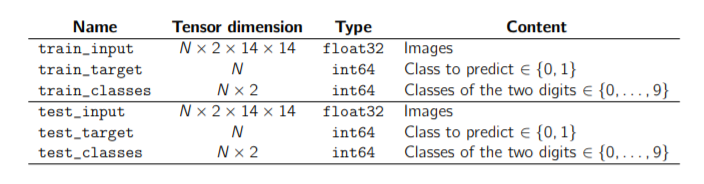

## Objective
The goal of the project is to compare different architectures, and assess the performance improvement that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can in particular take advantage of the availability of the classes of the two digits in each pair, beside the Boolean value truly of interest. All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000 parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error rate. Performance estimates provided in your report should be estimated through 10+ rounds for each architecture, where both data and weight initialization are randomized, and you should provide estimates of standard deviations

Need to add normalization of the train data. 

### Load the data

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
N = 1000

%matplotlib inline

In [2]:
train_inputs, train_targets, train_classes, test_inputs, test_targets, test_classes = prologue.generate_pair_sets(N)

# Normalize the training sets
mu, std = train_inputs.mean(), train_inputs.std() 
train_inputs.sub_(mu).div_(std)

# Normalize the test sets
test_inputs.sub_(mu).div_(std)

train_targets, test_targets = train_targets.float(), test_targets.float()

### Get a sense of it

Let us print the sizes of the tensors:

In [3]:
for name, tensor in zip(['train_input', 'train_target', 'train_classes', 'test_input', 'test_target', 'test_classes'], 
                        [train_inputs, train_targets, train_classes, test_inputs, test_targets, test_classes]):
    print(name, tensor.size())

train_input torch.Size([1000, 2, 14, 14])
train_target torch.Size([1000])
train_classes torch.Size([1000, 2])
test_input torch.Size([1000, 2, 14, 14])
test_target torch.Size([1000])
test_classes torch.Size([1000, 2])


In [4]:
(train_targets == 1).sum().item()

551

In [5]:
train_targets.size()

torch.Size([1000])

Everything looks fine!

Now let us make sure that the `train_target` really corresponds to the `train_classes`.

In [163]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [6]:
# For example, for the first one
print('train_classes are', train_classes[0])
print('train_target is', train_targets[0])

# For example, for the fourth one
print('train_classes are', train_classes[4])
print('train_target is', train_targets[4])

# For example, for the sixth one
print('train_classes are', train_classes[6])
print('train_target is', train_targets[6])

train_classes are tensor([9, 3])
train_target is tensor(0.)
train_classes are tensor([8, 8])
train_target is tensor(1.)
train_classes are tensor([8, 9])
train_target is tensor(1.)


In [7]:
from torch.utils.data import DataLoader, TensorDataset

In [8]:
test = TensorDataset(test_inputs, test_targets, test_classes)
train = TensorDataset(train_inputs, train_targets, train_classes)
train, val = torch.utils.data.random_split(train, [800, 200])

Funny, but everything looks fine!

In [9]:
class EarlyStopping:
    def __init__(self, patience, delta=0, mode='max'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.best_value = None
        self.counter = 0

    def __call__(self, value):
        if self.patience is None:
            return False

        if self.best_value is None:
            self.best_value = value
            self.counter = 0
            return False

        if self.mode == 'max':
            if value > self.best_value + self.delta:
                return self._positive_update(value)
            else:
                return self._negative_update(value)

        elif self.mode == 'min':
            if value < self.best_value - self.delta:
                return self._positive_update(value)
            else:
                return self._negative_update(value)

        else:
            raise ValueError(f"Illegal mode for early stopping: {self.mode}")

    def _positive_update(self, value):
        self.counter = 0
        self.best_value = value

        return False

    def _negative_update(self, value):
        self.counter += 1
        if self.counter > self.patience:
            return True
        else:
            return False

In [156]:
def f():
    return 1, 2, 3

In [166]:
get_n_params(TwoChannel())

44085

In [157]:
isinstance(f(), Iterable)

True

In [198]:
def compute_accuracy(model, data, mini_batch_size=100):
    """
        Compute the number of errors the model infers on the data set.

        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model
        data: Dataset
        mini_batch_size : int
            The size of the batch processing size

        Returns
        -------
        int
            The number of errors the model infers
    """
    loader = DataLoader(data, mini_batch_size)
    nb_errors = 0

    # Processing the data set by mini batches
    for data_input, target, _ in loader:
        output = model(data_input)
        if isinstance(output, tuple):
            output = next(iter(output))
        pred = output >= 0
        #print(pred, output, pred != output)
        nb_errors += (pred != target).sum().item()

    return 1 - (nb_errors / len(data))

In [199]:
def train_model(model, train, val, mini_batch_size=100, lr=1e-3, nb_epochs=20, patience=3):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        train : train dataset
            The input train label set
        val : validation dataset
        mini_batch_size : int
            The size of the batch processing size
        remember_train_losses : boolean
            True if remember train losses for model evaluation, False if not
        remember_test_losses : boolean
            True if remember test losses for model evaluation, False if not   
        lr : float
            Learning rate for the model training
        nb_epochs : int
            The number of epochs used to train the model
            
        Returns
        -------
        
        (NN object, train loss history, val accuracy history)
    """
    train_losses = []
    val_accs = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Defining the early stopping criterion
    early_stopping = EarlyStopping(patience)
    
    # Defining dataloaders
    train_loader = DataLoader(train, mini_batch_size, shuffle=True)
    
    # Learning loop
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for train_input, train_target, _ in train_loader:
            output = model(train_input)
            loss = criterion(output, train_target) 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        
        train_losses.append(loss)
        val_accs.append(compute_accuracy(model, val, mini_batch_size))
        
        if early_stopping(val_accs[-1]):
            break

           
    return model, train_losses, val_accs

# Architectures

## Convnet with two signals corresponding to each image.

In [200]:
class TwoChannel(nn.Module):
    def __init__(self, nb_hidden = 128):        
        super(TwoChannel, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.fc3 = nn.Linear(10, 1)
        
        ## we can play by 
        ## 1. add more and different layers
        ## 2. change number of hidden unit. Actually I think here is too much for the input dimension
        ## 3. kernel size but this should fit

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2)) 
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x).view(-1)
        
        return x

In [201]:
two_channel_net = TwoChannel()
two_channel_net, train_losses, val_accs = \
    train_model(two_channel_net, train, val, lr=0.0003, nb_epochs=100, patience=None)

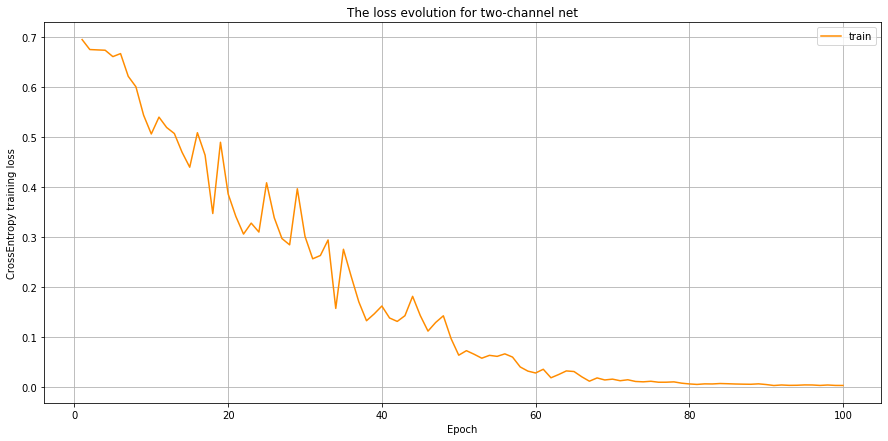

In [202]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(train_losses) + 1), train_losses, 'darkorange', label='train')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-channel net')
ax.legend();

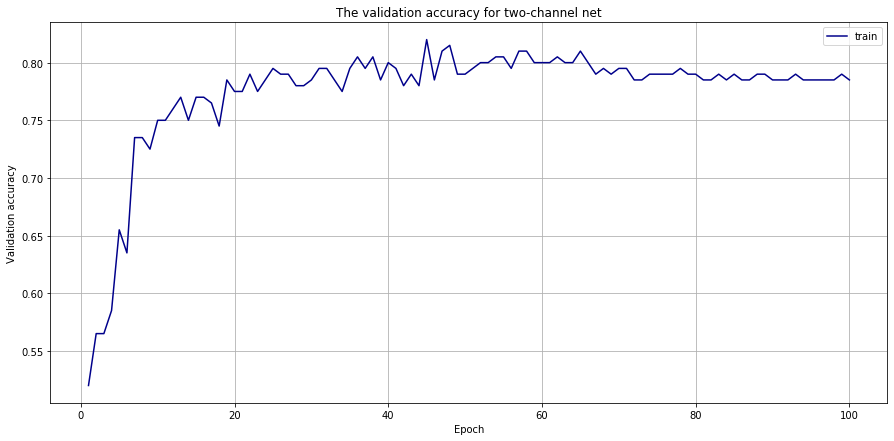

In [203]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(val_accs) + 1), val_accs, 'darkblue', label='train')
ax.set_ylabel('Validation accuracy')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The validation accuracy for two-channel net')
ax.legend();

In [204]:
train_accuracy = compute_accuracy(two_channel_net, train)
test_accuracy = compute_accuracy(two_channel_net, test)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Train accuracy: {test_accuracy:.3f}")

Train accuracy: 1.000
Train accuracy: 0.813


## Convnet with two branches, each processes her own image.

In [153]:
class TwoBranch(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranch, self).__init__()
        
        # Convolutional layers on the first branch
        self.cnn_first = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the first branch
        self.fc_first = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
            
        )
        
        # Convolutional layers on the second branch
        self.cnn_second = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the second branch
        self.fc_second = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
            
        )
    
    def forward_first(self, x):
        x = self.cnn_first(x)
        x = x.view(x.size(0), -1)
        x = self.fc_first(x)
        return x
    
    def forward_second(self, x):
        x = self.cnn_second(x)
        x = x.view(x.size(0), -1)
        x = self.fc_second(x)
        return x

    def forward(self, x):
        output_1 = self.forward_first(x[:, 0, None])
        output_2 = self.forward_second(x[:, 1, None])
        output = (output_2 - output_1).view(-1)
        return output

In [154]:
net = TwoBranch()
net, train_losses, val_accs = \
    train_model(net, train, val, lr=0.0003, nb_epochs=100)

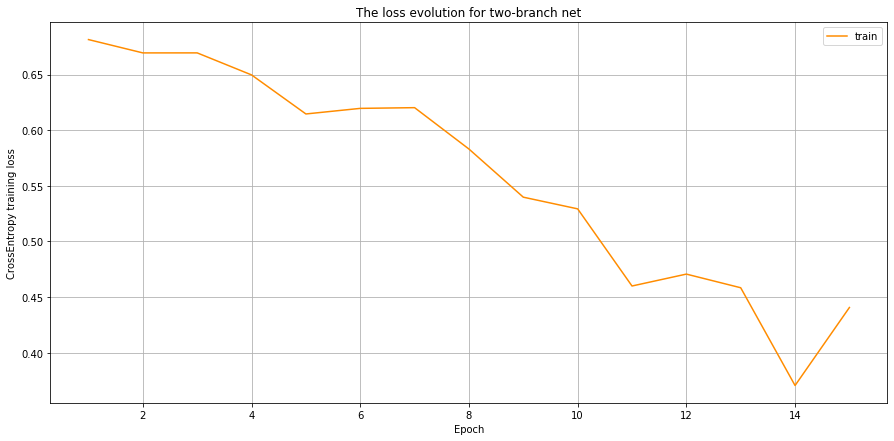

In [155]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(train_losses) + 1), train_losses, 'darkorange', label='train')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-branch net')
ax.legend();

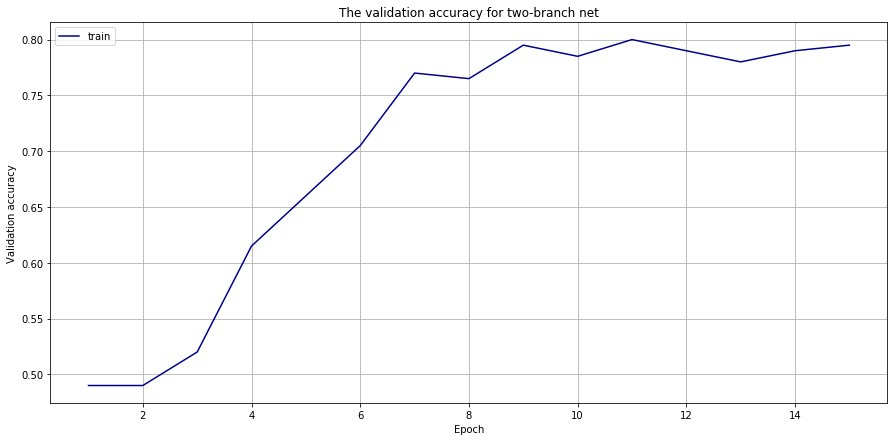

In [156]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(val_accs) + 1), val_accs, 'darkblue', label='train')
ax.set_ylabel('Validation accuracy')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The validation accuracy for two-branch net')
ax.legend();

In [157]:
train_accuracy = compute_accuracy(net, train)
test_accuracy = compute_accuracy(net, test)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Train accuracy: {test_accuracy:.3f}")

Train accuracy: 0.853
Train accuracy: 0.795


## Convnet with two branches, each processes her own image + weight sharing.

In [160]:
class TwoBranchWeightSharing(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchWeightSharing, self).__init__()
        
        # Convolutional layers in each branch
        self.cnn_single = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers in each branch
        self.fc_single = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
            
        )
        
    
    def forward_single(self, x):
        x = self.cnn_single(x)
        x = x.view(x.size(0), -1)
        x = self.fc_single(x)
        return x

    def forward(self, x):
        output_1 = self.forward_single(x[:, 0, None])
        output_2 = self.forward_single(x[:, 1, None])
        output = (output_2 - output_1).view(-1)
        return output

In [161]:
net = TwoBranchWeightSharing()
net, train_losses, val_accs = \
    train_model(net, train, val, lr=0.0003, nb_epochs=100)

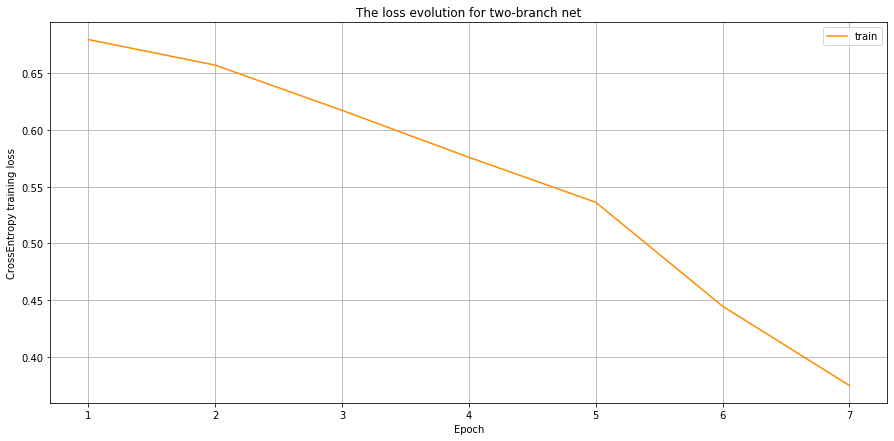

In [162]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(train_losses) + 1), train_losses, 'darkorange', label='train')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-branch net')
ax.legend();

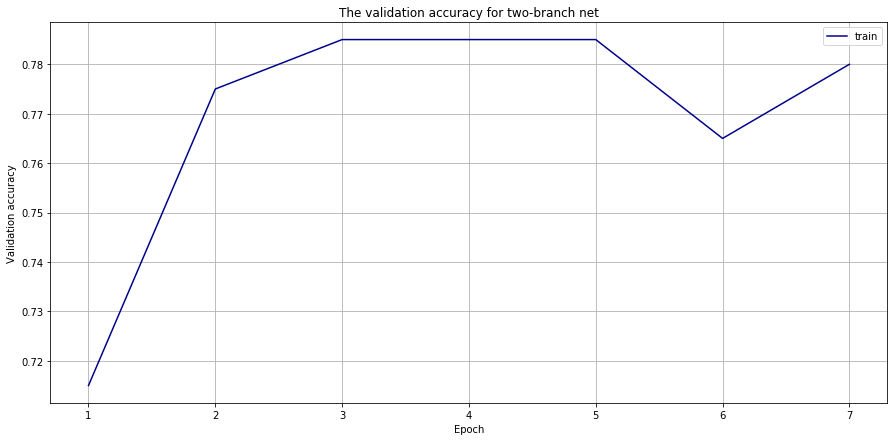

In [163]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(val_accs) + 1), val_accs, 'darkblue', label='train')
ax.set_ylabel('Validation accuracy')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The validation accuracy for two-branch net')
ax.legend();

In [164]:
train_accuracy = compute_accuracy(net, train)
test_accuracy = compute_accuracy(net, test)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Train accuracy: {test_accuracy:.3f}")

Train accuracy: 0.804
Train accuracy: 0.791


## Convnet with two branches, each processes her own image -> different architecture.

In [180]:
class TwoBranchSecond(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSecond, self).__init__()
        
        # Convolutional layers on the first branch
        self.cnn_first = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the first branch
        self.fc_first = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            
        )
        
        # Convolutional layers on the second branch
        self.cnn_second = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the second branch
        self.fc_second = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            
        )
        
        self.fc_prefinal = nn.Linear(20, 10)
        self.fc_final = nn.Linear(10, 1)
    
    def forward_first(self, x):
        x = self.cnn_first(x)
        x = x.view(x.size(0), -1)
        x = self.fc_first(x)
        return x
    
    def forward_second(self, x):
        x = self.cnn_second(x)
        x = x.view(x.size(0), -1)
        x = self.fc_second(x)
        return x

    def forward(self, x):
        output_1 = self.forward_first(x[:, 0, None])
        output_2 = self.forward_second(x[:, 1, None])
        output = torch.cat((output_1, output_2), 1)
        output = F.relu(self.fc_prefinal(output))
        output = self.fc_final(output).view(-1)
        return output

In [181]:
net = TwoBranchSecond()
net, train_losses, val_accs = \
    train_model(net, train, val, lr=0.0003, nb_epochs=100)

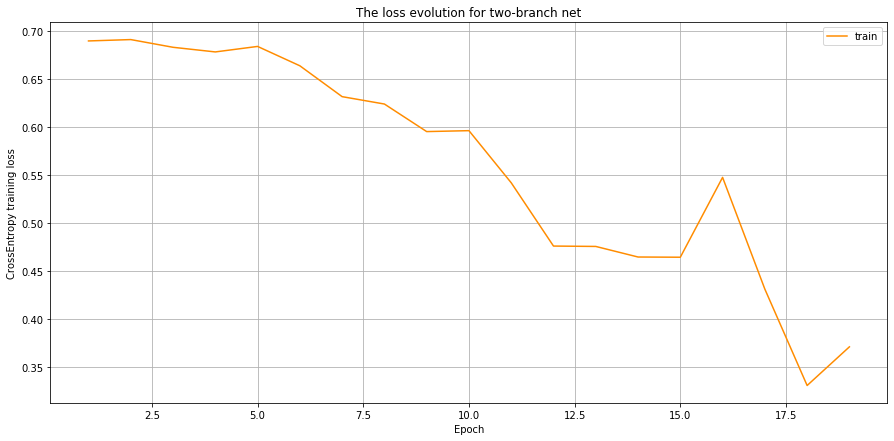

In [182]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(train_losses) + 1), train_losses, 'darkorange', label='train')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-branch net')
ax.legend();

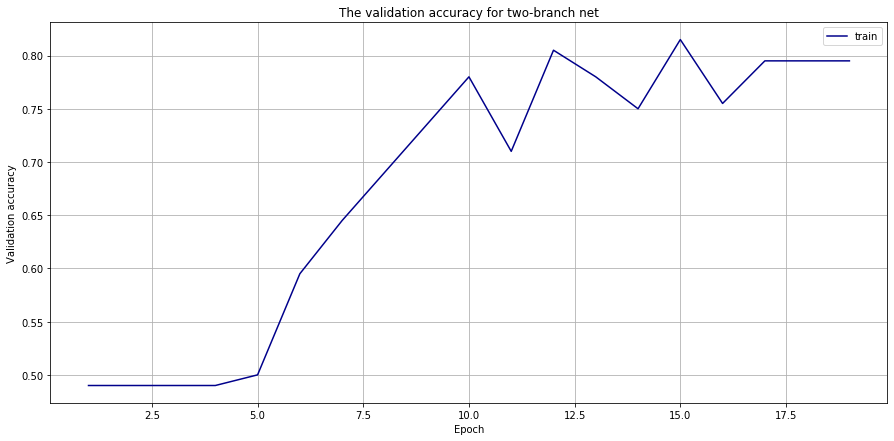

In [183]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(val_accs) + 1), val_accs, 'darkblue', label='train')
ax.set_ylabel('Validation accuracy')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The validation accuracy for two-branch net')
ax.legend();

In [184]:
train_accuracy = compute_accuracy(net, train)
test_accuracy = compute_accuracy(net, test)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Train accuracy: {test_accuracy:.3f}")

Train accuracy: 0.829
Train accuracy: 0.781


## Convnet with two branches, each processes her own image -> different architecture + weight sharing.

In [185]:
class TwoBranchSecondWeightSharing(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSecondWeightSharing, self).__init__()
        
        # Convolutional layers in each branch
        self.cnn_single = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers in each branch
        self.fc_single = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            
        )
        
        self.fc_prefinal = nn.Linear(20, 10)
        self.fc_final = nn.Linear(10, 1)
        
    def forward_single(self, x):
        x = self.cnn_single(x)
        x = x.view(x.size(0), -1)
        x = self.fc_single(x)
        return x

    def forward(self, x):
        output_1 = self.forward_single(x[:, 0, None])
        output_2 = self.forward_single(x[:, 1, None])
        output = torch.cat((output_1, output_2), 1)
        output = F.relu(self.fc_prefinal(output))
        output = self.fc_final(output).view(-1)
        return output

In [190]:
net = TwoBranchSecondWeightSharing()
net, train_losses, val_accs = \
    train_model(net, train, val, lr=0.0003, nb_epochs=100)

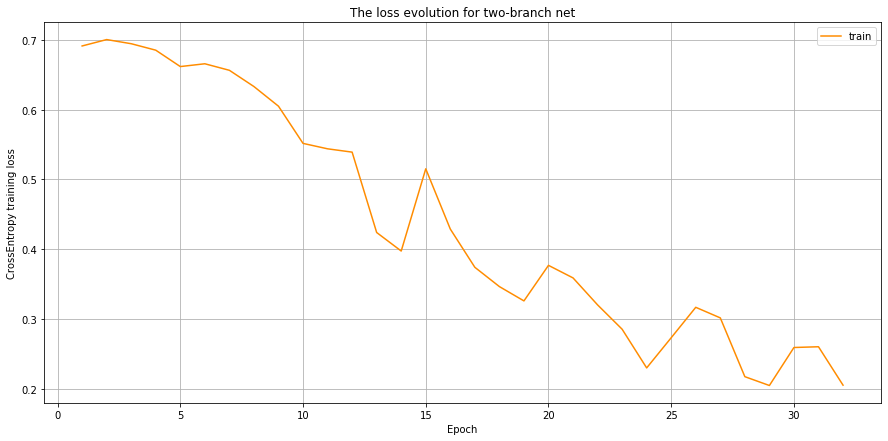

In [191]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(train_losses) + 1), train_losses, 'darkorange', label='train')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-branch net')
ax.legend();

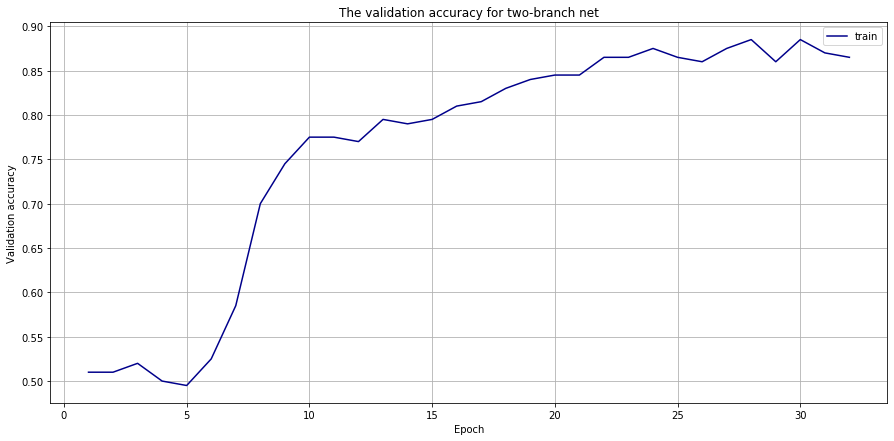

In [192]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(val_accs) + 1), val_accs, 'darkblue', label='train')
ax.set_ylabel('Validation accuracy')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The validation accuracy for two-branch net')
ax.legend();

In [193]:
train_accuracy = compute_accuracy(net, train)
test_accuracy = compute_accuracy(net, test)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Train accuracy: {test_accuracy:.3f}")

Train accuracy: 0.927
Train accuracy: 0.835


## Convnet with two branches, each processes her own image -> different architecture + weight sharing + auxiliary losses.

In [215]:
def train_model_auxiliary(model, train, val, auxiliary_weight=1., mini_batch_size=100, 
                          lr=1e-3, nb_epochs=20, patience=3):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        train : train dataset
            The input train label set
        val : validation dataset
        auxiliary_weight: float
            Coefficient of auxiliary loss
        mini_batch_size : int
            The size of the batch processing size
        remember_train_losses : boolean
            True if remember train losses for model evaluation, False if not
        remember_test_losses : boolean
            True if remember test losses for model evaluation, False if not   
        lr : float
            Learning rate for the model training
        nb_epochs : int
            The number of epochs used to train the model
            
        Returns
        -------
        
        NN object or (NN object, list) or (NN object, list, list)
            If either remember_train_losses or remember_test_losses
            is True then the function returns both the trained model 
            and the list of train/test losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
            If both remember_train_losses or remember_test_losses
            are True then the function returns the trained model 
            and lists of train and test losses for each epoch.
    """
    train_losses = []
    val_accs = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.BCEWithLogitsLoss()
    criterion_digit = nn.CrossEntropyLoss()
    
    # Defining the early stopping criterion
    early_stopping = EarlyStopping(patience)
    
    # Defining dataloaders
    train_loader = DataLoader(train, mini_batch_size, shuffle=True)
    
    # Learning loop
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for train_input, train_target, train_class in train_loader:
            output, output_first_digit, output_second_digit = model(train_input)
            loss_comparison = criterion(output, train_target)
            loss_digits = criterion_digit(output_first_digit, train_class[:, 0]) + \
                          criterion_digit(output_second_digit, train_class[:, 1])
            loss = loss_comparison + auxiliary_weight * loss_digits
            
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        
        train_losses.append(loss)
        val_accs.append(compute_accuracy(model, val, mini_batch_size))
        
        if early_stopping(val_accs[-1]):
            break

           
    return model, train_losses, val_accs

In [216]:
class TwoBranchSecondWeightSharingAuxiliaryLoss(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSecondWeightSharingAuxiliaryLoss, self).__init__()
        
        # Convolutional layers in each branch
        self.cnn_single = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers in each branch
        self.fc_single = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            
        )
        
        self.fc_prefinal = nn.Linear(2*nb_hidden, 100)
        self.fc_comparison = nn.Linear(100, 1)
        self.fc_first_digit = nn.Linear(100, 10)
        self.fc_second_digit = nn.Linear(100, 10)
        
    def forward_single(self, x):
        x = self.cnn_single(x)
        x = x.view(x.size(0), -1)
        x = self.fc_single(x)
        return x

    def forward(self, x):
        output_1 = self.forward_single(x[:, 0, None])
        output_2 = self.forward_single(x[:, 1, None])
        output = torch.cat((output_1, output_2), 1)
        output = F.relu(self.fc_prefinal(output))
        output_comparison = self.fc_comparison(output).view(-1)
        output_first_digit = self.fc_first_digit(output)
        output_second_digit = self.fc_second_digit(output)
        return output_comparison, output_first_digit, output_second_digit

In [230]:
net = TwoBranchSecondWeightSharingAuxiliaryLoss()
net, train_losses, val_accs = \
    train_model_auxiliary(net, train, val, lr=0.0003, nb_epochs=100, patience=20)

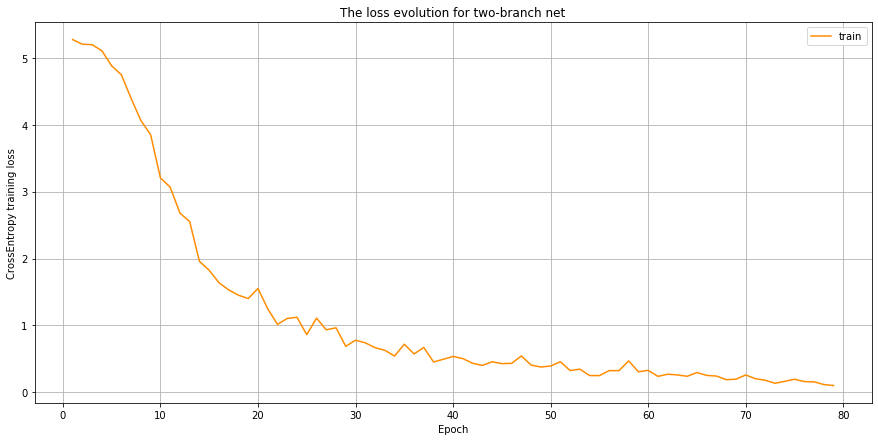

In [231]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(train_losses) + 1), train_losses, 'darkorange', label='train')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-branch net')
ax.legend();

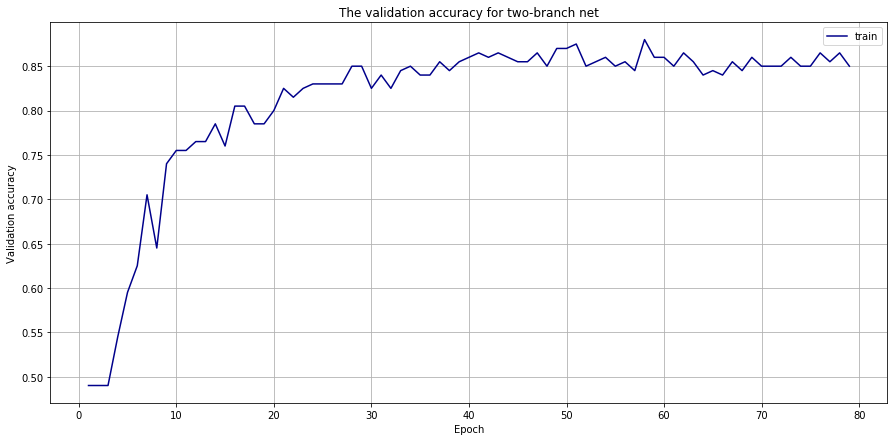

In [232]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(val_accs) + 1), val_accs, 'darkblue', label='train')
ax.set_ylabel('Validation accuracy')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The validation accuracy for two-branch net')
ax.legend();

In [233]:
train_accuracy = compute_accuracy(net, train)
test_accuracy = compute_accuracy(net, test)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Train accuracy: {test_accuracy:.3f}")

Train accuracy: 0.983
Train accuracy: 0.867


¯\_(ツ)_/¯

## Just classification + direct comparison

In [13]:
def compute_accuracy_classification(model, data, mini_batch_size=100):
    
    """
        Compute the number of errors the model infers on the data set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        tensor_inputs : torch.Tensor object
            The input feature set
        targets : torch.Tensor object
            The input label set
        mini_batch_size : int
            The size of the batch processing size
            
        Returns
        -------
        int
            The number of errors the model infers
    """
    loader = DataLoader(data, mini_batch_size)
    nb_errors = 0
    
    # Processing the data set by mini batches
    for data_input, target, _ in loader:
        output = model(data_input).argmax(dim=-1).reshape(-1, 2)
        pred = output[:, 0] <= output[:, 1]
        nb_errors += (pred != target).sum().item()
                
    return 1 - (nb_errors / len(data))

In [150]:
def train_model_classification(model, train, val, mini_batch_size=100, 
                          lr=1e-3, nb_epochs=20, patience=3):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        train : train dataset
        val : validation dataset
        mini_batch_size : int
            The size of the batch processing size
        remember_train_losses : boolean
            True if remember train losses for model evaluation, False if not
        remember_test_losses : boolean
            True if remember test losses for model evaluation, False if not   
        lr : float
            Learning rate for the model training
        nb_epochs : int
            The number of epochs used to train the model
            
        Returns
        -------
        
        NN object or (NN object, list) or (NN object, list, list)
            If either remember_train_losses or remember_test_losses
            is True then the function returns both the trained model 
            and the list of train/test losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
            If both remember_train_losses or remember_test_losses
            are True then the function returns the trained model 
            and lists of train and test losses for each epoch.
    """
    train_losses = []
    val_accs = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.CrossEntropyLoss()
    
    # Defining the early stopping criterion
    early_stopping = EarlyStopping(patience)
    
    # Defining dataloaders
    train_loader = DataLoader(train, mini_batch_size, shuffle=False)
    
    # Learning loop
    # plt.figure(figsize=(7, 10 * 5 * nb_epochs))
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for train_input, train_target, train_class in train_loader:
            output = model(train_input.reshape(-1, 1, *train_input.shape[2:]))
#             x = train_input.reshape(-1, 1, *train_input.shape[2:])
#             d = train_class.reshape(-1)
            
#             for i in range(20):
#                 plt.subplot(10 * nb_epochs, 2, e * 20 + i + 1)
#                 plt.title(f"{d[i].item()}")
#                 plt.imshow(x[i, 0].numpy())
            #print(train_class.reshape(-1), output)
            loss = criterion(output, train_class.reshape(-1))
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            #break
        
        train_losses.append(loss.item())
        val_accs.append(compute_accuracy_classification(model, val, mini_batch_size))

        if early_stopping(val_accs[-1]):
            break

           
    return model, train_losses, val_accs

In [151]:
class Classification(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(Classification, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        
    def forward_single(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2)) 
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x).view(-1, 10)

    def forward(self, x):
        return self.forward_single(x.reshape(-1, 1, *x.shape[2:]))

In [152]:
net = Classification()
net, train_losses, val_accs = \
    train_model_classification(net, train, val, lr=0.0003, mini_batch_size=100, nb_epochs=100, patience=20)

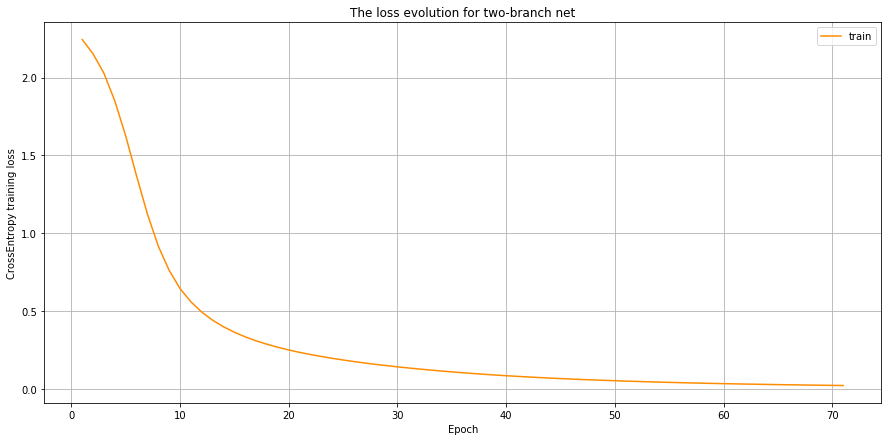

In [153]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(train_losses) + 1), train_losses, 'darkorange', label='train')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-branch net')
ax.legend();

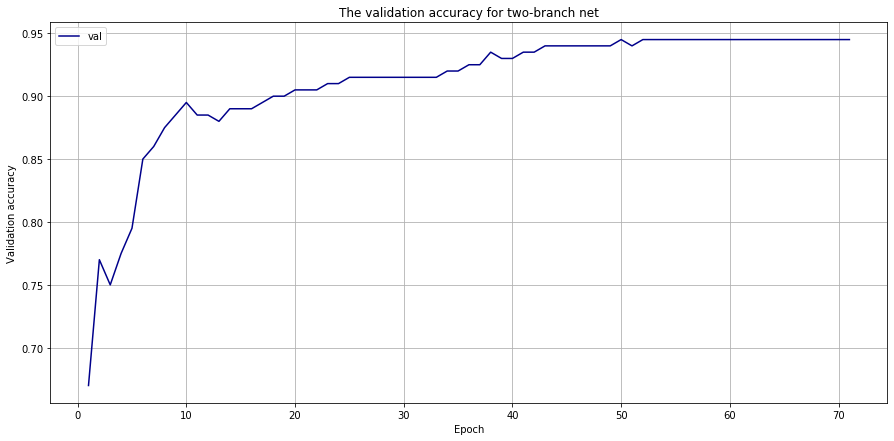

In [154]:
# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(range(1, len(val_accs) + 1), val_accs, 'darkblue', label='val')
ax.set_ylabel('Validation accuracy')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The validation accuracy for two-branch net')
ax.legend();

In [155]:
train_accuracy = compute_accuracy_classification(net, train)
test_accuracy = compute_accuracy_classification(net, test)
print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

Train accuracy: 0.998
Test accuracy: 0.962
